# Application 1: The Quantum Harmonic Oscillator

### Background

Consider the Schrodinger equation for the 1-d Harmonic Oscillator:

\begin{align}
&\Big(- \frac{d^{2}}{dx^{2}} + \alpha x^{2}  - \lambda \Big) \phi = 0 \\
&F_{\alpha}\Big( \phi_{\alpha}(x) \Big) = 0 
\end{align}
 where $\lambda = 2 m E$ is the eigenvalue with energy $E$ and $\alpha = m^{2} \omega^{2}$ is the harmonic oscillator parameter. We want to find solutions to this equation for many values of $\alpha$ without repeatly solving the Schrodinger equation directly. We do this by constructing an approximate solution
\begin{align}
\hat{\phi}_{\alpha_{k}}(x) = \sum_{i=1}^{n} a_{i} \phi_{i}(x) 
\end{align}
where $\phi_{i}(x)$ are exact solutions to the Schrodinger equation for chosen values of $\alpha$. The goal of this tutorial is to show how Galerkin projection can be used to construct an approximate solution $\hat{\phi}_{\alpha_{k}}(x)$ that is significantly cheaper to evaluate for any $\alpha$ of interest and to quantify the error of  $\hat{\phi}_{\alpha_{k}}(x)$ and approximate eigenvalues $\hat{\lambda}_{\alpha_{k}}$.

In [1]:
import numpy as np
import scipy as sci
from scipy import optimize
from scipy import special
import matplotlib.pyplot as plt

In [2]:
### NOTE: hbar = 1 in this demo
### First define exact solutions to compare numerical solutions to.
def getPsi_x(n,k):
    '''
    Definition of exact HO wavefunction taken from Zettili page 240.
    
    Parameters
    ----------
    n : TYPE
        principle quantum number for SE equation
    k : TYPE
        harmonic oscillator parameter (mass*omega)^2 from the potential term \mu^2 \omega^{2} x^{2} in the SE.

    Returns
    -------
    wf : function
        1-d wavefunction for the 1d-harmonic oscillator as a function of position x. 
    '''
    herm = special.hermite(n)
    def wf(x):
        result = (1/np.sqrt(np.sqrt(np.pi)*2**(n)*np.math.factorial(n)*(k)**(.25)))*np.exp(-x**(2)*np.sqrt(k)/2)*herm(x*k**(.25))
        return(result)
    return wf
def getExactLambda(n,mass,alpha):
    '''
    Exact eigenvalues of the HO equation. -f''(x) + k x^2 f(x) = 2 m E f(x)
    Lambda = 2 m E  
    E = (n + .5) \omega 
    \alpha = m^2 \omega^2 
    \omega = \sqrt{alpha/m^2}
    Parameters
    ----------
    n : float
        principle quantum number. float integers
    omega : float
        oscillator frequency.

    Returns
    -------
    float
        oscillator energy 2mE. 
    '''
    return 2*mass*(.5 + n)*np.sqrt(alpha/mass**2)
def V(x,alpha):
    '''
    1-d harmonic Oscillator potential

    Parameters
    ----------
    x : float or nd array
        position.
    alpha : float
        oscillator length parameter.

    Returns
    -------
    float or ndarray
        value of potential evaluated at x.

    '''
    return alpha*x**2
def construct_H(V,grid,mass,alpha):
    '''
    Uses 2nd order finite difference scheme to construct a discretized differential H operator
    Note: mass is fixed to 1 for this demo.

    Parameters
    ----------
    V : TYPE
        DESCRIPTION.
        
    alpha : TYPE
        oscillator parameter alpha used in V(x) = alpha*x**2.

    Returns
    -------
    H : ndarray
        2d numpy array
    '''
    dim = len(grid)
    off_diag = np.zeros(dim)
    off_diag[1] = 1
    H = -1*(-2*np.identity(dim) + sci.linalg.toeplitz(off_diag))/(mass*h**2) + np.diag(V(grid,alpha))
    return H
def solve(H,grid,h):
    '''
    Parameters
    ----------
    H : 2d ndarray
        Hamiltonian Matrix.
    grid : ndarray
        Discretized 1d domain.
    h : float
        grid spacing.

    Returns
    -------
    evals : ndarray
        returns nd array of eigenvalues of H. 
    evects : ndarray
        returns ndarray of eigenvectors of H.
    Eigenvalues and eigenvectors are ordered in ascending order. 
    '''
    evals,evects = np.linalg.eigh(H)
    evects = evects.T
    for i,evect in enumerate(evects):
        #norm = np.sqrt(1/sci.integrate.simpson(evect*evect,grid))
        norm = 1/(np.linalg.norm(np.dot(evect,evect)))
        evects[i] = evects[i]*norm
    return evals,evects

def getSystem(H,psi_array,phi_array):
    '''
    Sets up syetem of equations for Galerkin projection <\phi_{j},F_{k}(phi_{k})>

    Parameters
    ----------
    H : ndarray
        Hamiltonian matrix.
    psi_array : ndarray
        array of projector functions. Assumes rows are corresponding to discretized functions
    phi_array : TYPE
        DESCRIPTION.

    Returns
    -------
    Function
        Function that takes in a vector of parameters of the form (a_{1},a_{2},....,\lambda_{\alpha}) 
        and outputs of the system of equations. \lambda_{\alpha} is the eigenvalue of HO equation.
    '''
    ## 
    def system(a_vec):
        '''
        Parameters
        ----------
        a_vec : ndarray
            vector of parameters (a_{k},\lambda).

        Returns
        -------
        results : ndarray
            outputs of the Galerkin projection equations and normalization functions <\hat{\phi}|\hat{\phi}> = 1.
            This systems can be solved using sci.optimize.fsolve or using your choice of method.
        '''
        results = np.zeros(len(a_vec))
        results[-1] = -1 # from normalization
        for i in np.arange(0,len(a_vec)-1,1):
            for k in np.arange(0,len(a_vec)-1,1):
                results[i] += a_vec[k]*np.dot(psi_array[i],np.matmul(H,phi_array[k])) - \
                a_vec[-1]*a_vec[k]*np.dot(psi_array[i],phi_array[k])
        for k in np.arange(0,len(a_vec)-1,1):
            for kp in np.arange(0,len(a_vec)-1,1):
                results[-1] += a_vec[kp]*a_vec[k]*np.dot(psi_array[kp],phi_array[k])
        return results
    return system

In [3]:
#First define global variables
h = 10**(-2) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).
### HO global parameters 
n = 0 # principle quantum number to solve in HO
mass = 1.0 # mass for the HO system
# define the domain boundaries
x_a = -10 # left boundary 
x_b = 10 # right boundary 
x_array = np.arange(x_a,x_b+h,h)
m = len(x_array) 
print('Number of grid points: ',m)

Number of grid points:  2001


### Solving "Exactly"

First select a set of values of $\alpha$ to solve the SE with. These solutions will be used as the basis in the reduced basis model.

In [4]:
# Select alpha values to use to solve SE exactly.
alpha_vals = [.5,5,10,15]  #Here, we choose 3 values of alpha to solve exactly. This results in 3 basis functions
# initialize solution arrays. T is the matrix that will hold wavefunction solutions. 
# T has the form T[i][j], i = alpha, j = solution components
T = np.zeros((len(alpha_vals),m)) 
# T_evals holds the eigenvalues for each evect in T. 
T_evals = np.zeros(len(alpha_vals))

Now solve the SE for selected values of alpha and compare numerical solution to exact solution

alpha = 0.5, lambda = 0.7071036561722082
alpha = 0.5, exact lambda = 0.7071067811865476
alpha = 5, lambda = 2.236036727063778
alpha = 5, exact lambda = 2.23606797749979
alpha = 10, lambda = 3.1622151589324003
alpha = 10, exact lambda = 3.1622776601683795
alpha = 15, lambda = 3.872889593938531
alpha = 15, exact lambda = 3.872983346207417


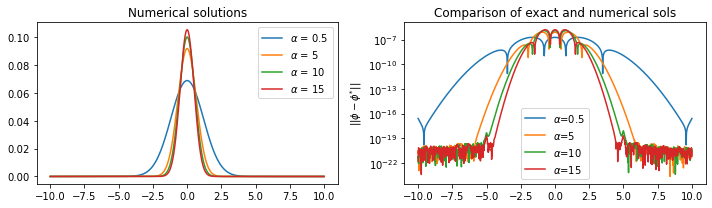

|lambda - lambda_exact| = 3.1250143394112584e-06
|lambda - lambda_exact| = 3.1250436011820426e-05
|lambda - lambda_exact| = 6.250123597917323e-05
|lambda - lambda_exact| = 9.375226888597155e-05


In [10]:
for i,alpha_sample in enumerate(alpha_vals):
    H = construct_H(V,x_array,mass,alpha_sample) # construct the Hamiltonian matrix for given alpha_sample.
    evals, evects = solve(H,x_array,h) # solve the system for evals and evects.
    T[i] = evects[n]/np.linalg.norm(evects[n]) # assign the nth evect to solution array T
    T_evals[i] = evals[n] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'alpha = {alpha_sample}, lambda = {evals[n]}')
    print(f'alpha = {alpha_sample}, exact lambda = {getExactLambda(n,mass,alpha_sample)}')

    
## Checks to make sure numerical solutions are accurate:
# Make plots comparing the numerical wavefunction to the exact wavefunction
fig, ax = plt.subplots(1,2,figsize=(10,3))
for i in range(len(alpha_vals)):
    wf = getPsi_x(n,alpha_vals[i])
    wf_vals = wf(x_array)/np.linalg.norm(wf(x_array))
    diff = np.abs(wf_vals - T[i])
    ax[0].plot(x_array,np.abs(T[i]),label=r'$\alpha$ = '+str(alpha_vals[i]))
    ax[1].semilogy(x_array,diff,label=r'$\alpha$='+str(alpha_vals[i]))
ax[0].set_title('Numerical solutions')
ax[1].set_title('Comparison of exact and numerical sols')
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel(r'$||\phi-\phi^{*}||$')
fig.tight_layout()
plt.show()

# print error of eigenvalue 
for i in range(len(alpha_vals)):
    diff = np.abs(getExactLambda(n,mass,alpha_vals[i]) - T_evals[i])
    print(f'|lambda - lambda_exact| = {diff}')

### Visiting the PCA Doctor

Now apply PCA Doctor to see if our problem can be approximated by a reduced basis.

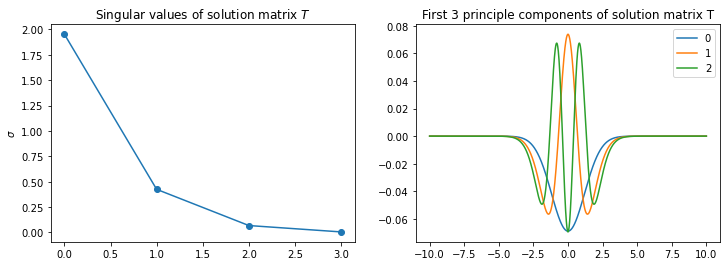

In [6]:
U, s, Vh = np.linalg.svd(T)
n_comps = 3 # number of principle components to plot (i.e number of column vectors of SVD matrix V to plot)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(s,'o-')
ax[0].set_title(r'Singular values of solution matrix $T$')
ax[0].set_ylabel(r'$\sigma$')
for i in np.arange(0,n_comps,1):
    ax[1].plot(x_array,Vh[:,i],label=str(i))
ax[1].set_title(f'First {n_comps} principle components of solution matrix T')
ax[1].legend()
plt.show()

PCA Doctor shows the singular values of the solution matrix T are decreasing as we move down the diagonal of the matrix of singular values resulting from the singular value decomposition. This tells us that as we increase the number of basis elements, we gain less and less information. This implies that reduced basis methods are applicable to our problem and solutions can be well approximated by just a few basis elements. Also note the principle components in the right panel.

### Constructing the Basis and Comparing

Now that we know RBM is applicable to our problem, we now construct a reduced basis for the Schrodinger equation.

Here we explicitly construct $ \hat{\phi}_{\alpha_{k}}= \sum_{i=1}^{n} a_{i} \phi_{i}$ using the Galerkin method, that is, projecting $F_{\alpha_{k}}\big( \hat{\phi}_{\alpha_{k}}(x) \big)$ over $n$ linearly independent functions projecting functions $\{ \psi_{i}\}_{i=1}^{n}$.  

\begin{align}
\langle \psi_{i}, F_{\alpha_{k}}\big( \hat{\phi}_{\alpha_{k}}(x) \big) \rangle = 0 
\end{align}

We can interpret this as enforcing the orthogonality of $F_{\alpha_{k}}\big( \hat{\phi}_{\alpha_{k}}(x) \big)$ to the subspace spanned by $\{\psi_{i}\}$ that is, by finding $\hat{\phi}_{\alpha}$ such that $F_{\alpha_{k}}(\hat{\psi}_{\alpha_{k}})$ is approximately zero up to the ability of the set $\{\psi_{i}\}$. The choice of projecting functions $\{ \psi_{i} \}$ is arbitrary, but is usually also informed by the solution manifold. Here we choose the solution set $\{ \phi_{i} \}$ to be our projecting functions. This leads to an equation $n$ equations for the coeffecients $a_{k}$. However, since $\lambda$ is also unknown, we need an additional equation. This comes from the normalization conditions 

\begin{align}
\langle \hat{\phi}_{\alpha_{k}},\hat{\phi}_{\alpha_{k}} \rangle  = 1
\end{align}

This results in $n +1$ equations for the $n$ unknown coeffecients $a_{k}$ and eigenvalue $\lambda$.


Coeffecients a_k: [-0.02001628  0.72240374 -3.01421624  3.31046244]
Appproximate lambda: 5.00117556128781
Exact lambda: 5.0
lambda difference: 0.0011755612878099342


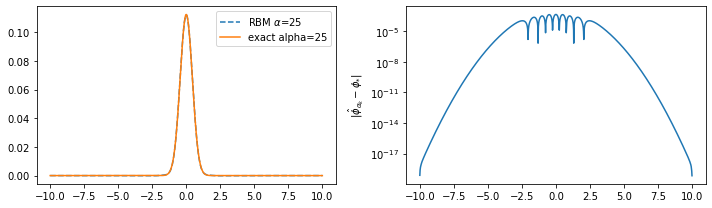

In [7]:
# Now we can construct our RBM for an alpha of our choosing. 
alpha_k = 25
H_k = construct_H(V,x_array,mass,alpha_k) # construct the Hamiltonian Matrix for new value of alpha
# For our projectors, we choose the same basis \phi_{i}
psi = T.copy()
# Now construct system of equations we need to solve. See definition of getSystem function above 
# to see how this is setup.
ak_system = getSystem(H_k,psi,T) 
# To solve this system, we use numpy's fsolve
#Note: the solutions for {a_{k}} and the eigenvalue \lambda depend on the guess. Different guesses might 
# result in the solving for an excited state we may or may not want. Giving an initial guess of a_{0} = 1
# and the rest 0 seems to work ok.
ak_guess = np.zeros(len(alpha_vals)+1) # of the form (a_{1},a_{2},..., a_{n},\lambda)
ak_guess[0] = 1
a_sols = optimize.fsolve(ak_system, ak_guess)

print(f'Coeffecients a_k: {a_sols[:len(a_sols)-1]}')
print(f'Appproximate lambda: {a_sols[-1]}')
print(f'Exact lambda: {getExactLambda(n,mass,alpha_k)}')
print(f'lambda difference: {abs(getExactLambda(n,mass,alpha_k)-a_sols[-1])}')

approx_sol = np.zeros(len(H_k))
for i in range(len(a_sols)-1):
    approx_sol += a_sols[i]*T[i]
norm = np.linalg.norm(approx_sol)
true_wf = getPsi_x(n, alpha_k)
error = np.abs(true_wf(x_array)/np.linalg.norm(true_wf(x_array)) - approx_sol)

## Make plots of RBM solution and the exact solution
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(x_array,approx_sol,'--',label=r'RBM $\alpha$='+str(alpha_k))
ax[0].plot(x_array,true_wf(x_array)/np.linalg.norm(true_wf(x_array)),label='exact alpha='+str(alpha_k))
ax[1].semilogy(x_array,error)
ax[0].legend()
ax[1].set_ylabel(r'$|\hat{\phi}_{\alpha_{k}}-\phi_{*}|$')
fig.tight_layout()
plt.show()